<a href="https://colab.research.google.com/github/ppkk0906/Caba_nlp/blob/main/DL5_1_using_convnets_with_small_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy
baseDir= './drive/MyDrive/Colab Notebooks/DeepLearning/dataset/cats_and_dogs_small'
trainDir = os.path.join(baseDir,"train")
validationDir = os.path.join(baseDir, "validation")
testDir = os.path.join(baseDir, "test")

# 고양이 디렉토리
trainCatsDir = os.path.join(trainDir, "cats")
validationCatsDir = os.path.join(validationDir, "cats")
testCatsDir = os.path.join(testDir, "cats")

# 강아지 디렉토리
trainDogsDir = os.path.join(trainDir, "dogs")
validationDogsDir = os.path.join(validationDir, "dogs")
testDogsDir = os.path.join(testDir, "dogs")

In [28]:
print("훈련용 고양이 이미지 개수:", len(os.listdir(trainCatsDir)))
print("검증용 고양이 이미지 개수:", len(os.listdir(validationCatsDir)))
print("시험용 고양이 이미지 개수:", len(os.listdir(testCatsDir)))
print("훈련용 강아지 이미지 개수:", len(os.listdir(trainDogsDir)))
print("검증용 강아지 이미지 개수:", len(os.listdir(validationDogsDir)))
print("시험용 강아지 이미지 개수:", len(os.listdir(testDogsDir)))

훈련용 고양이 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
시험용 고양이 이미지 개수: 500
훈련용 강아지 이미지 개수: 1000
검증용 강아지 이미지 개수: 500
시험용 강아지 이미지 개수: 500


In [29]:
import keras
keras.__version__

'2.4.3'

In [30]:
from keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation="relu", input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

## 데이터 전처리
    데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 합니다. 지금은 데이터가 JPEG 파일로 되어 있으므로 네트워크에 주입하려면 대략 다음 과정을 따릅니다.

1. 사진 파일을 읽습니다.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3. 그다음 부동 소수 타입의 텐서로 변환합니다.
4. 픽셀 값(0에서 255 사이)의 스케일을 \[0, 1] 사이로 조정합니다(신경망은 작은 입력 값을 선호합니다).
5. 케라스는 keras.preprocessing.image에 이미지 처리를 위한 헬퍼 도구를 가지고 있다.  
대표적인 클래스가 imageDataGenerator이며 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동 변환하는 파이썬 제너레이터를 만들어 준다.

In [31]:
from keras.preprocessing.image import ImageDataGenerator 
trainDataGen = ImageDataGenerator(rescale=1./255)
testDataGen = ImageDataGenerator(rescale=1./255)

trainGenerator = trainDataGen.flow_from_directory(
    trainDir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)
validationGenerator = testDataGen.flow_from_directory(
    validationDir,
    target_size=(150,150),
    batch_size=20,
    class_mode="binary"
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
for data_batch, label_batch in trainGenerator:
  print("배치 데이터 크기", data_batch.shape)
  print("배치 레이블 크기", label_batch.shape)
  break

배치 데이터 크기 (20, 150, 150, 3)
배치 레이블 크기 (20,)


## 제너레이터를 사용한 데이터에 모델을 훈련

* <c>fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있다.</c>
* 이 메서드는 첫 번째 매개변수로 입력과 타깃의 배치를 끝없이 반환하는 파이썬 제너레이터를 기대한다.
* 데이터가 끝없이 생성되기 때문에 케라스 모델에 하나의 에포크를 정의하기 위해 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지 알려 주어야 한다.
* steps_per_epoch 매개변수에서 이를 설정한다.
* 제너레이터로부터 steps_per_epoch 개의 배치만큼 뽑은 다음, 즉 steps_per_epoch 횟수만큼 경사 하강법 단계를 실행한 다음에 훈련 프로세스는 다음 에포크로 넘어간다.
* 20개의 샘플이 하나의 배치이므로 2,000개의 샘플을 모두 처리할 때까지 100개의 배치를 뽑을 것이다.
* fit_generator를 사용할 때 fit 메서드와 마찬가지로 validation_data 매개변수를 전달할 수 있다.
* 이 매개변수에는 데이터 제너레이터도 가능하지만 넘파이 배열의 튜플도 가능하다.
* validation_data로 제너레이터를 전달하면 검증 데이터의 배치를 끝없이 반환한다.
* 따라서 검증 데이터 제너레이터에서 얼마나 많은 배치를 추출하여 평가할지 validation_steps 매개변수에 지정해야 한다.

In [33]:
history = model.fit(
    trainGenerator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = validationGenerator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 114s 1s/step - loss: 1.8753 - acc: 0.4988 - val_loss: 0.6883 - val_acc: 0.5240
Epoch 2/30
100/100 [==============================] - 112s 1s/step - loss: 0.6879 - acc: 0.5790 - val_loss: 0.6286 - val_acc: 0.6290
Epoch 3/30
100/100 [==============================] - 113s 1s/step - loss: 0.5873 - acc: 0.6908 - val_loss: 0.7384 - val_acc: 0.6330
Epoch 4/30
100/100 [==============================] - 113s 1s/step - loss: 0.5254 - acc: 0.7364 - val_loss: 0.6427 - val_acc: 0.6850
Epoch 5/30
100/100 [==============================] - 113s 1s/step - loss: 0.4273 - acc: 0.7914 - val_loss: 0.7235 - val_acc: 0.6520
Epoch 6/30
100/100 [==============================] - 113s 1s/step - loss: 0.3586 - acc: 0.8339 - val_loss: 0.8051 - val_acc: 0.7020
Epoch 7/30
100/100 [==============================] - 113s 1s/step - loss: 0.3154 - acc: 0.8524 - val_loss: 0.7000 - val_acc: 0.7280
Epoch 8/30
100/100 [==============================] - 113s 1s/step - 

In [34]:
# 모델 저장
model.save("/drive/MyDrive/Colab Notebooks/DeepLearning/cats and dogs small 1.h5")


In [35]:
# 모델 불러오기
from keras.models import load_model
# model = load_model("/drive/MyDrive/Colab Notebooks/DeepLearning/cats and dogs small 1.h5")

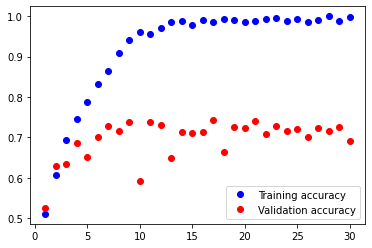

In [36]:
import matplotlib.pyplot as plt
epochs = range(1, 31)
histories = history.history
plt.plot(epochs, histories["acc"], "bo", label="Training accuracy")
plt.plot(epochs, histories["val_acc"], "ro", label="Validation accuracy")
plt.legend()

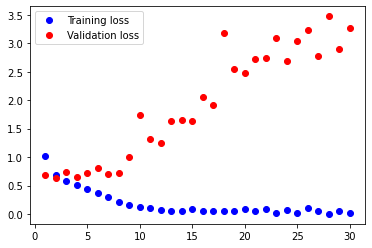

In [37]:
plt.plot(epochs, histories["loss"], "bo", label="Training loss")
plt.plot(epochs, histories["val_loss"], "ro", label="Validation loss")
plt.legend()